In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
import os

from tensorflow.keras.optimizers import Adam
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
# 加载 CIFAR-10 数据
import random
import numpy as np
# Load and preprocess CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


2024-07-06 10:44:10.332016: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
##该模型并没有使用双重对齐，因为我使用的数据错了。

In [3]:
from torchvision import transforms
import imageio
import numpy as np
from PIL import Image
from random import sample


import copy
from copy import deepcopy
import random
import PIL
from torchvision.transforms import functional as F
import torch.nn as nn
from torchvision.transforms import Compose


class AddTrigger:
    def __init__(self):
        pass

    def add_trigger(self, img, noise=False):
        """Add WaNet trigger to image.

        Args:
            img (torch.Tensor): shape (C, H, W).
            noise (bool): turn on noise mode, default is False

        Returns:
            torch.Tensor: Poisoned image, shape (C, H, W).
        """
        if noise:
            ins = torch.rand(1, self.h, self.h, 2) * self.noise_rescale - 1  # [-1, 1]
            grid = self.grid + ins / self.h
            grid = torch.clamp(self.grid + ins / self.h, -1, 1)
        else:
            grid = self.grid
        poison_img = nn.functional.grid_sample(img.unsqueeze(0), grid, align_corners=True).squeeze()  # CHW
        return poison_img


class AddCIFAR10Trigger(AddTrigger):
    """Add WaNet trigger to CIFAR10 image.

    Args:
        identity_grid (orch.Tensor): the poisoned pattern shape.
        noise_grid (orch.Tensor): the noise pattern.
        noise (bool): turn on noise mode, default is False.
        s (int or float): The strength of the noise grid. Default is 0.5.
        grid_rescale (int or float): Scale :attr:`grid` to avoid pixel values going out of [-1, 1].
            Default is 1.
        noise_rescale (int or float): Scale the random noise from a uniform distribution on the
            interval [0, 1). Default is 2.
    """

    def __init__(self, identity_grid, noise_grid, noise=True, s=0.9, grid_rescale=1, noise_rescale=2):
        super(AddCIFAR10Trigger, self).__init__()

        self.identity_grid = deepcopy(identity_grid)
        self.noise_grid = deepcopy(noise_grid)
        self.h = self.identity_grid.shape[2]
        self.noise = noise
        self.s = s
        self.grid_rescale = grid_rescale
        grid = self.identity_grid + self.s * self.noise_grid / self.h
        self.grid = torch.clamp(grid * self.grid_rescale, -1, 1)
        self.noise_rescale = noise_rescale

    def __call__(self, img):
        img = F.pil_to_tensor(img)
        img = F.convert_image_dtype(img, torch.float)
        img = self.add_trigger(img, noise=self.noise)
        img = img.numpy().transpose(1, 2, 0)
        img = Image.fromarray(np.clip(img*255,0,255).round().astype(np.uint8))
        # img = Image.fromarray(img.permute(1, 2, 0).numpy())
        return img


import torch
import torch.nn.functional as tF

# 设置设备为 CUDA (GPU) 如果可用，否则使用 CPU

device = torch.device("cpu")

# CIFAR10 图像尺寸
input_height, input_width = 32, 32

# 创建 identity_grid
y, x = torch.meshgrid(torch.linspace(-1, 1, input_height), torch.linspace(-1, 1, input_width))
identity_grid = torch.stack((x, y), 2).unsqueeze(0).to(device)

# 创建噪声 pattern
ins = torch.randn(1, 1, input_height, input_width).to(device)  # 随机噪声
noise_grid = tF.interpolate(ins, size=(input_height, input_width), mode="bicubic", align_corners=True)
noise_grid = noise_grid.permute(0, 2, 3, 1).to(device)

trigger = AddCIFAR10Trigger(identity_grid, noise_grid)



/home/xipeng/anaconda3/envs/keras2/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:

# 选择1%的训练数据进行攻击
num_samples = int(0.1 * x_val.shape[0])
indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

target_class = 1  # 目标类别
num_classes = 10  # CIFAR-10 数据集的类别数



x_val_tigger = x_val.copy()
y_val_tigger = y_val.copy()

for i in range(len(x_val_tigger)):
    img = x_val_tigger[i]  # 获取单个图像
    img_pil = Image.fromarray((img * 255).astype(np.uint8)) 
    poisoned_img_tensor = trigger(img_pil)
    transform_to_tensor = transforms.ToTensor()
    poisoned_img_tensor = transform_to_tensor(poisoned_img_tensor)
# 将 PyTorch 张量转换为 NumPy 数组
    poisoned_img_np = poisoned_img_tensor.numpy().transpose(1, 2, 0)
    x_val_tigger[i] = poisoned_img_np  
    
        
    
    
x_test_tigger = x_test.copy()
y_test_tigger = y_test.copy()

    
    
for i in range(len(x_test)):
    img = x_test_tigger[i]  # 获取单个图像
    img_pil = Image.fromarray((img * 255).astype(np.uint8)) 
    poisoned_img_tensor = trigger(img_pil)
    transform_to_tensor = transforms.ToTensor()
    poisoned_img_tensor = transform_to_tensor(poisoned_img_tensor)
# 将 PyTorch 张量转换为 NumPy 数组
    poisoned_img_np = poisoned_img_tensor.numpy().transpose(1, 2, 0)
    x_test_tigger[i] = poisoned_img_np  
    y_test_tigger[i] = to_categorical(target_class, num_classes=10)

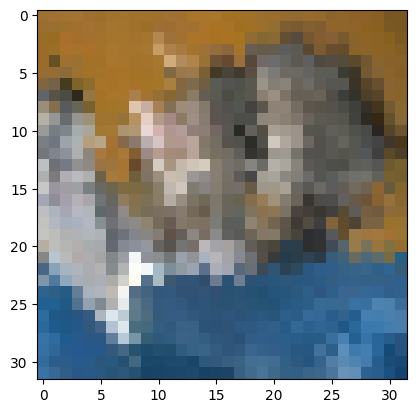

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x_test_tigger[0])

plt.show()

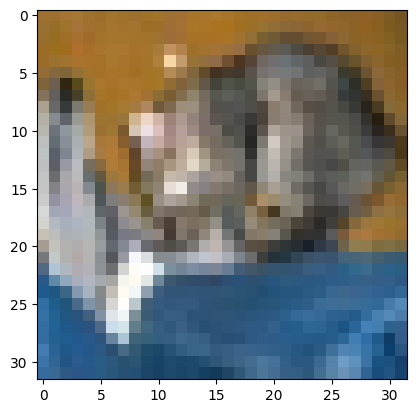

In [6]:
import matplotlib.pyplot as plt
plt.imshow(x_test[0])

plt.show()

In [7]:
##进行攻击的思路
#1.将数据集分成两部分  8比2吧
#2.每个epcoch后再单独优化一下服务器模型，保持模拟的客户端模型不变，后门数据要多一些
#3.验证数据集结果

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models



def create_client_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    # 第一层卷积
    x = layers.Conv2D(32, 3, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # 第二层卷积
    x = layers.Conv2D(64, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # 新增的第三层卷积
    x = layers.Conv2D(128, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    model = models.Model(inputs=input_layer, outputs=x)
    return model


In [9]:
from tensorflow.keras import layers, models

def res_block(filters, strides):
    def block(x):
        shortcut = x

        x = layers.Conv2D(filters, 3, padding='same', strides=strides)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        # 捷径连接前的调整
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        return x
    return block

def create_server_model():
    # 调整输入层的定义以匹配修改后的客户端模型的输出
    input_layer = layers.Input(shape=(32, 32, 128))  # 注意这里的变化

    # 残差块定义保持不变，继续使用提前定义的 res_block
    x = res_block(128, 1)(input_layer)  # 使用第一个残差块
    x = res_block(128, 2)(x)            # 使用第二个残差块
    x = res_block(128, 2)(x)           # 使用第三个残差块
    x = res_block(256, 2)(x)           # 使用第四个残差块

    # 全局平均池化和输出层保持不变
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(10, activation='softmax')(x)
    
    model = models.Model(inputs=input_layer, outputs=output)
    return model





In [10]:
# 创建客户端模型
client_model = create_client_model(input_shape=(32, 32, 3))

# 编译客户端模型
client_model.compile(optimizer=Adam(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


2024-07-06 10:44:38.754543: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-07-06 10:44:38.799826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-07-06 10:44:38.799885: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2024-07-06 10:44:38.802998: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-07-06 10:44:38.806153: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2024-07-06 10:44:38.806663: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcu

In [11]:
client_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)       

In [12]:
# 以下是服务器模型训练的简化示例
server_model = create_server_model()
server_model.compile(optimizer=Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [13]:
##创建三个影子模型，分别是1层卷积，2层卷积核3层卷积


In [14]:
def create_client_model_1(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(128, (3, 3), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    model = models.Model(inputs=input_layer, outputs=x)
    return model


def create_client_model_2(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    model = models.Model(inputs=input_layer, outputs=x)
    return model
def create_client_model_3(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    model = models.Model(inputs=input_layer, outputs=x)
    return model
def create_client_model_4(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    model = models.Model(inputs=input_layer, outputs=x)
    return model

def create_client_model_5(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    # 第一层卷积
    x = layers.Conv2D(32, (3, 3), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # 第二层卷积
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # 第三层卷积
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # 第四层卷积
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # 第五层卷积
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    model = models.Model(inputs=input_layer, outputs=x)
    return model


In [15]:
# Assuming TensorFlow is installed and the functions are defined in your script
input_shape = (32, 32, 3)

client_model_1 = create_client_model_3(input_shape=(32, 32, 3))


# You can then print the model summaries to verify their structures
print(client_model_1.summary())




Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 64)       

In [16]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# 定义训练步骤
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape_client, tf.GradientTape() as tape_server:
        # 客户端前向传播
        client_outputs = client_model(x, training=True)
        # 服务器前向传播      
        server_logits = server_model(client_outputs, training=True)
        # 计算损失
        loss = loss_fn(y, server_logits)

    # 计算服务器模型梯度
    grads_server = tape_server.gradient(loss, server_model.trainable_variables)
    # 更新服务器模型权重
    optimizer_server.apply_gradients(zip(grads_server, server_model.trainable_variables))

    # 计算客户端模型梯度（模拟反向传播）
    grads_client = tape_client.gradient(loss, client_model.trainable_variables)
    # 更新客户端模型权重
    optimizer_client.apply_gradients(zip(grads_client, client_model.trainable_variables))

    return loss


In [17]:

# 假设 optimizer_client 和 optimizer_server 已经被定义
optimizer_client_1 = tf.keras.optimizers.Adam()  # 为 client_model_1 定义一个新的优化器

@tf.function
def train_step_2(x, y):
    # 首次使用客户端和服务器模型进行训练
    with tf.GradientTape() as tape_client, tf.GradientTape() as tape_server:
        client_outputs = client_model(x, training=True)  # 客户端模型前向传播
        server_logits = server_model(client_outputs, training=True)  # 服务器模型前向传播
        loss = loss_fn(y, server_logits)  # 计算损失

    # 计算并应用服务器模型梯度
    grads_server = tape_server.gradient(loss, server_model.trainable_variables)
    optimizer_server.apply_gradients(zip(grads_server, server_model.trainable_variables))

    # 计算并应用客户端模型梯度
    grads_client = tape_client.gradient(loss, client_model.trainable_variables)
    optimizer_client.apply_gradients(zip(grads_client, client_model.trainable_variables))

    # 单独针对 client_model_1 的训练步骤
    with tf.GradientTape() as tape_client_1:
        client_outputs_1 = client_model_1(x, training=True)  # client_model_1 前向传播
        server_logits_1 = server_model(client_outputs_1, training=False)  # 使用 server_model 进行前向传播但不更新
        loss_1 = loss_fn(y, server_logits_1)  # 计算损失

    # 计算并应用 client_model_1 的梯度
    grads_client_1 = tape_client_1.gradient(loss_1, client_model_1.trainable_variables)
    optimizer_client_1.apply_gradients(zip(grads_client_1, client_model_1.trainable_variables))

    return loss, loss_1  # 返回两步训练的损失值

# 注意：在实际使用中，确保已经正确初始化了所有模型（client_model, client_model_1, server_model）
# 以及优化器（optimizer_client, optimizer_server, optimizer_client_1）


In [18]:
@tf.function
def train_step_client(x, y):
    # 使用客户端和服务器模型进行训练
    with tf.GradientTape() as tape_client, tf.GradientTape() as tape_server:
        # 客户端模型前向传播
        client_outputs = client_model(x, training=True)
        # 服务器模型前向传播
        server_logits = server_model(client_outputs, training=True)
        # 计算损失
        loss = loss_fn(y, server_logits)
    
    # 计算并应用服务器模型梯度
    grads_server = tape_server.gradient(loss, server_model.trainable_variables)
    optimizer_server.apply_gradients(zip(grads_server, server_model.trainable_variables))
    
    # 计算并应用客户端模型梯度
    grads_client = tape_client.gradient(loss, client_model.trainable_variables)
    optimizer_client.apply_gradients(zip(grads_client, client_model.trainable_variables))

    return loss


In [19]:
@tf.function
def train_step_client_1(x, y):
    # 仅针对client_model_1的训练步骤
    with tf.GradientTape() as tape_client_1:
        # client_model_1前向传播
        client_outputs_1 = client_model_1(x, training=True)
        # 使用server_model进行前向传播但不更新
        server_logits_1 = server_model(client_outputs_1, training=False)
        # 计算损失
        loss_1 = loss_fn(y, server_logits_1)

    # 计算并应用client_model_1的梯度
    grads_client_1 = tape_client_1.gradient(loss_1, client_model_1.trainable_variables)
    optimizer_client_1.apply_gradients(zip(grads_client_1, client_model_1.trainable_variables))

    return loss_1


In [20]:
@tf.function
def train_step_only_server(x, y):
    with tf.GradientTape() as tape_server:
        # 使用 client_model_1 进行前向传播，注意这里我们不更新 client_model_1
        client_outputs_1 = client_model_1(x, training=False)  # 注意这里的 training=False
        
        # 使用 server_model 进行前向传播，准备更新这个模型
        server_logits = server_model(client_outputs_1, training=True)
        
        # 计算损失
        loss = loss_fn(y, server_logits)

    # 计算服务器模型梯度并应用
    grads_server = tape_server.gradient(loss, server_model.trainable_variables)
    optimizer_server_2.apply_gradients(zip(grads_server, server_model.trainable_variables))

    return loss  # 返回训练损失值


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_combined_model(client_model, server_model, compile_only=False):
    # Getting the input of the client model
    client_input = client_model.input
    
    # Getting the intermediate output by passing the input through the client model
    client_output = client_model(client_input)
    
    # The client model's output is used as the input for the server model
    server_output = server_model(client_output)
    
    # Defining a new model that chains the client and server models
    combined_model = Model(inputs=client_input, outputs=server_output)
    
    # Compile the combined model
    combined_model.compile(optimizer=Adam(),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    
    if not compile_only:
        # If not compile_only, evaluate the model
        loss, accuracy = combined_model.evaluate(x_test, y_test, verbose=0)
        print(f"Test loss: {loss}, Test accuracy: {accuracy}")
    
    return combined_model

# Use the function to create and compile the combined model without evaluating


In [22]:
import tensorflow as tf

def change_batch(resblock_test_trigger, client_outputs, y):
    # 使用tf.random.uniform生成0到2000之间的随机整数索引
    random_integer = tf.random.uniform(shape=(), minval=0, maxval=2000, dtype=tf.int32)
    # 从resblock_test_trigger中选择一个随机元素
    selected_trigger = tf.gather(resblock_test_trigger, random_integer)
    # 确保selected_trigger的形状与client_outputs中的元素兼容
    selected_trigger = tf.expand_dims(selected_trigger, 0)  # 假设它是一个序列，需要扩展维度以兼容

    # 更新client_outputs的第一个元素
    client_outputs_updated = tf.concat([selected_trigger, client_outputs[1:]], axis=0)
    
    # 创建一个新标签
    new_label = tf.constant([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=y.dtype)
    # 使用tf.tensor_scatter_nd_update更新y的第一个样本的标签
    indices = tf.constant([[0]])  # 表示我们要更新第一个样本的标签
    updated_y = tf.tensor_scatter_nd_update(y, indices, tf.expand_dims(new_label, 0))

    return client_outputs_updated, updated_y


In [23]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# 定义训练步骤
@tf.function
def train_step_door(x, y,resblock_test_tigger):
    with tf.GradientTape() as tape_client, tf.GradientTape() as tape_server:
        # 客户端前向传播
        client_outputs = client_model(x, training=True)
        client_outputs_updated, updated_y = change_batch(resblock_test_tigger,client_outputs,y)
        # 服务器前向传播      
        server_logits = server_model(client_outputs_updated, training=True)
        # 计算损失
        loss = loss_fn(updated_y, server_logits)

    # 计算服务器模型梯度
    grads_server = tape_server.gradient(loss, server_model.trainable_variables)
    # 更新服务器模型权重
    optimizer_server.apply_gradients(zip(grads_server, server_model.trainable_variables))

    # 计算客户端模型梯度（模拟反向传播）
    grads_client = tape_client.gradient(loss, client_model.trainable_variables)
    # 更新客户端模型权重
    optimizer_client1.apply_gradients(zip(grads_client, client_model.trainable_variables))

    return loss


In [24]:
optimizer_client = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
optimizer_client1 = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
###这两个都是客户端的优化梯度

optimizer_server = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
##optimizer_server 和 这两个都是客户端的优化梯度的梯度要一模一样

optimizer_client_1 = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)


optimizer_server_2 = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)

In [25]:
batch_size = 32
def augment(image, label):
    # 随机水平翻转图像
    image = tf.image.random_flip_left_right(image)
    # 随机调整亮度
    image = tf.image.random_brightness(image, max_delta=0.1)
    # 确保图像值仍然在0到1的范围内
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# 假设x_train, y_train, x_val, y_val, x_val_tigger, y_val_tigger已经定义并准备好了

# 训练数据集 - 应用数据增强
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(augment).shuffle(len(x_train)).batch(batch_size)

# 客户端验证数据集 - 也应用数据增强
client_1_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
client_1_dataset = client_1_dataset.map(augment).shuffle(len(x_val)).batch(batch_size)


In [26]:
# 初始化TensorBoard回调
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 60




combined_model = create_combined_model(client_model, server_model, compile_only=True)
combined_model_1 = create_combined_model(client_model_1, server_model, compile_only=True)


epoch_losses = []
epoch_accuracies = []


epoch_losses_1 = []
epoch_accuracies_1 = []


epoch_losses_2= []
epoch_accuracies_2 = []


epoch_losses_3= []
epoch_accuracies_3 = []
# 开始训练

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_loss_avg_server = tf.keras.metrics.Mean()

#先训练

for epoch in range(5):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_loss_avg_server = tf.keras.metrics.Mean()
    for x_batch, y_batch in train_dataset:
        loss = train_step_client(x_batch, y_batch)
    print(f"  Client Model Loss: {loss.numpy():.4f}")

    for x_batch, y_batch in client_1_dataset:   ##只修改这部分
        loss_1 = train_step_client_1(x_batch, y_batch)
    print(f"  Client Model 1 Loss: {loss_1.numpy():.4f}")

    loss, accuracy = combined_model.evaluate(x_test, y_test, verbose=0)
    epoch_losses.append(loss)
    epoch_accuracies.append(accuracy)
    
    loss, accuracy = combined_model_1.evaluate(x_test, y_test, verbose=0)
    epoch_losses_1.append(loss)
    epoch_accuracies_1.append(accuracy)
    
    loss, accuracy = combined_model.evaluate(x_test_tigger, y_test_tigger, verbose=0)
    epoch_losses_2.append(loss)
    epoch_accuracies_2.append(accuracy)
    
    loss, accuracy = combined_model_1.evaluate(x_test_tigger, y_test_tigger, verbose=0)
    epoch_losses_3.append(loss)
    epoch_accuracies_3.append(accuracy)
    
    
    
    

for epoch in range(55):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_loss_avg_server = tf.keras.metrics.Mean()
    
    # 客户端模型的训练， ######这一步修改输入数据。
    for x_batch, y_batch in train_dataset:
        resblock_test_tigger = client_model_1(x_val_tigger[0:2000])
        loss = train_step_door(x_batch, y_batch,resblock_test_tigger)
        
    # 模拟客户端模型的训练  client_1_dataset  
    for x_batch, y_batch in client_1_dataset:   ##只修改这部分
        loss_1 = train_step_client_1(x_batch, y_batch)
    print(f"  Client Model 1 Loss: {loss_1.numpy():.4f}")    
        
   
        

    
    
    print(f"Epoch {epoch}, Loss: {epoch_loss_avg.result().numpy()}")
    
    loss, accuracy = combined_model.evaluate(x_test, y_test, verbose=0)
    epoch_losses.append(loss)
    epoch_accuracies.append(accuracy)
    
    loss, accuracy = combined_model_1.evaluate(x_test, y_test, verbose=0)
    epoch_losses_1.append(loss)
    epoch_accuracies_1.append(accuracy)
    
    loss, accuracy = combined_model.evaluate(x_test_tigger, y_test_tigger, verbose=0)
    epoch_losses_2.append(loss)
    epoch_accuracies_2.append(accuracy)
    
    loss, accuracy = combined_model_1.evaluate(x_test_tigger, y_test_tigger, verbose=0)
    epoch_losses_3.append(loss)
    epoch_accuracies_3.append(accuracy)
    
    
    
    
    
    
    # 此处可添加其他回调，如ModelCheckpoint或EarlyStopping


2024-07-06 10:44:42.978152: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2024-07-06 10:44:42.978243: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2024-07-06 10:44:42.980494: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so.10.1
2024-07-06 10:44:43.081396: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2024-07-06 10:44:50.530900: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-07-06 10:44:50.896509: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2024-07-06 10:44:52.889532: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned

  Client Model Loss: 0.9919
  Client Model 1 Loss: 1.0570
  Client Model Loss: 0.7293
  Client Model 1 Loss: 0.5566
  Client Model Loss: 0.6445
  Client Model 1 Loss: 0.3481
  Client Model Loss: 0.4331
  Client Model 1 Loss: 0.3651
  Client Model Loss: 0.9896
  Client Model 1 Loss: 0.7892
  Client Model 1 Loss: 1.0621
Epoch 0, Loss: 0.0
  Client Model 1 Loss: 0.8110
Epoch 1, Loss: 0.0
  Client Model 1 Loss: 1.0087
Epoch 2, Loss: 0.0
  Client Model 1 Loss: 0.1325
Epoch 3, Loss: 0.0
  Client Model 1 Loss: 0.5906
Epoch 4, Loss: 0.0
  Client Model 1 Loss: 0.9543
Epoch 5, Loss: 0.0
  Client Model 1 Loss: 0.7644
Epoch 6, Loss: 0.0
  Client Model 1 Loss: 0.5240
Epoch 7, Loss: 0.0
  Client Model 1 Loss: 0.3932
Epoch 8, Loss: 0.0
  Client Model 1 Loss: 0.9137
Epoch 9, Loss: 0.0
  Client Model 1 Loss: 0.2931
Epoch 10, Loss: 0.0
  Client Model 1 Loss: 0.2021
Epoch 11, Loss: 0.0
  Client Model 1 Loss: 0.4357
Epoch 12, Loss: 0.0
  Client Model 1 Loss: 0.6041
Epoch 13, Loss: 0.0
  Client Model 1 Los

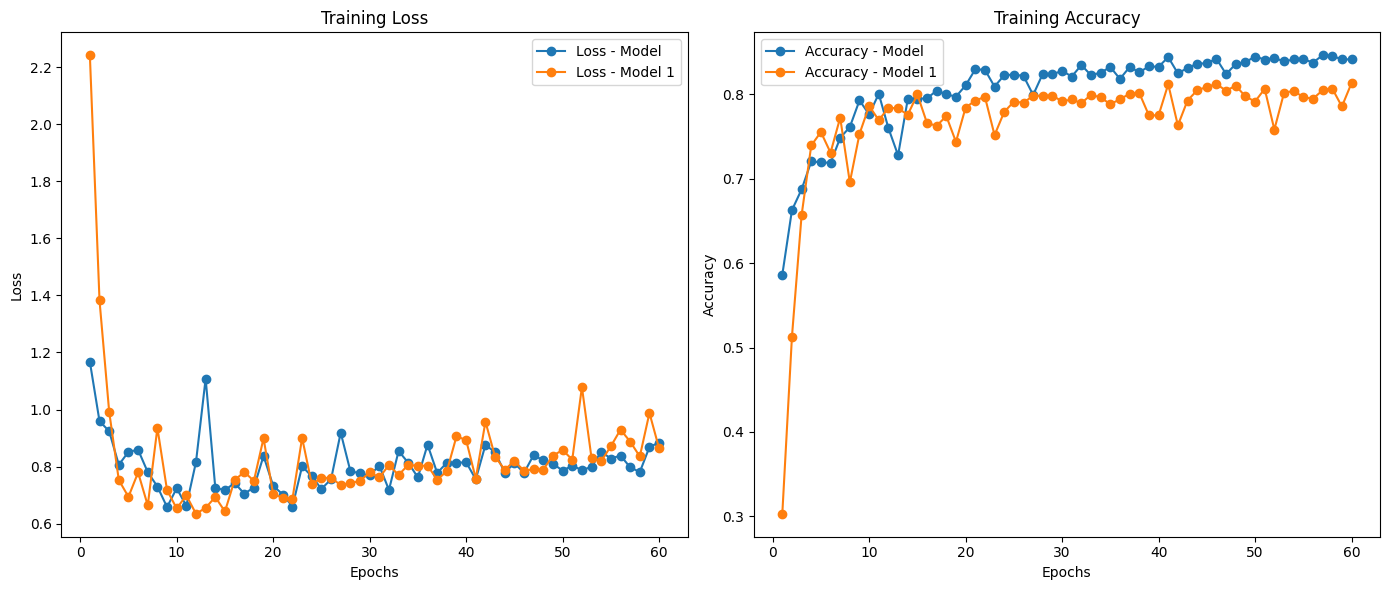

In [27]:
import matplotlib.pyplot as plt
epochs = range(1, len(epoch_losses) + 1)

plt.figure(figsize=(14, 6))

# 绘制 loss 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, label='Loss - Model', marker='o')
plt.plot(epochs, epoch_losses_1, label='Loss - Model 1', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制 accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_accuracies, label='Accuracy - Model', marker='o')
plt.plot(epochs, epoch_accuracies_1, label='Accuracy - Model 1', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

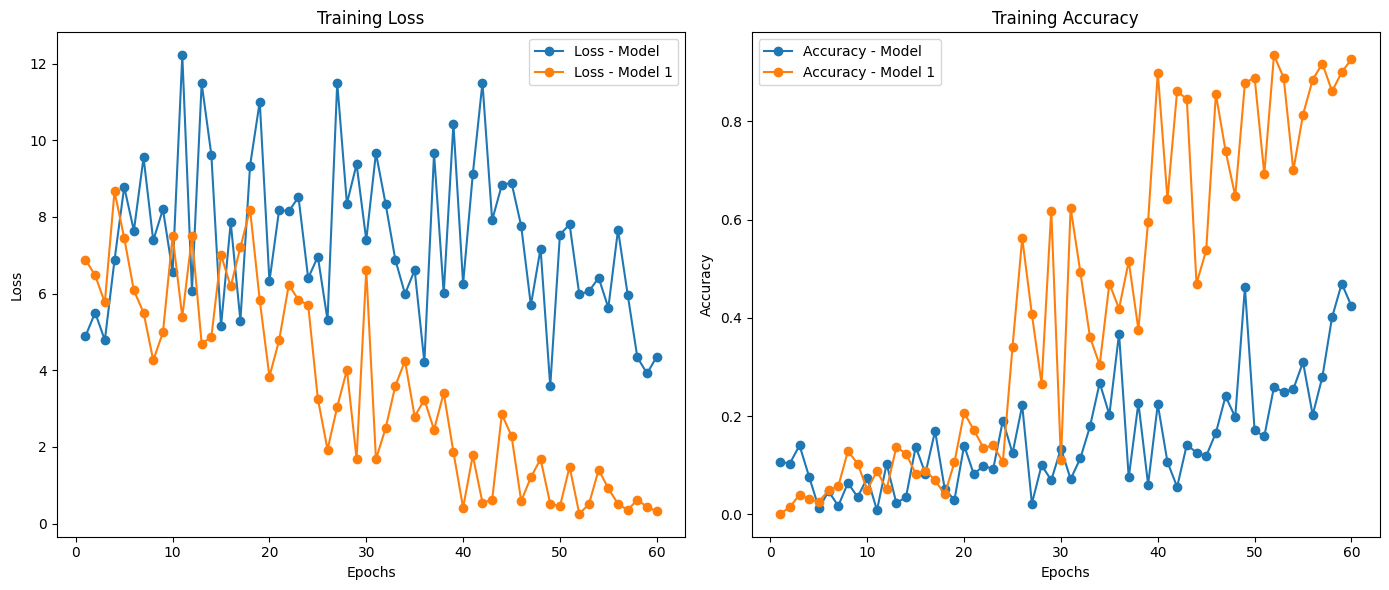

In [28]:
import matplotlib.pyplot as plt
epochs = range(1, len(epoch_losses) + 1)

plt.figure(figsize=(14, 6))

# 绘制 loss 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses_2, label='Loss - Model', marker='o')
plt.plot(epochs, epoch_losses_3, label='Loss - Model 1', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制 accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_accuracies_2, label='Accuracy - Model', marker='o')
plt.plot(epochs, epoch_accuracies_3, label='Accuracy - Model 1', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
max_accuracy_2 = max(epoch_accuracies_2)
max_accuracy_3 = max(epoch_accuracies_3)

# 输出最大值
print("Max accuracy for epoch_accuracies_2:", max_accuracy_2)
print("Max accuracy for epoch_accuracies_3:", max_accuracy_3)

Max accuracy for epoch_accuracies_2: 0.46959999203681946
Max accuracy for epoch_accuracies_3: 0.9343000054359436


In [29]:
from tensorflow.keras.models import Model

# 假设client_model和server_model的输入和输出层已经定义

# 获取客户端模型的输入
client_input = client_model.input

# 通过客户端模型获取中间输出
client_output = client_model(client_input)

# 将客户端的输出作为服务器模型的输入
server_output = server_model(client_output)

# 定义一个新的模型，该模型连接了客户端和服务器模型
combined_model = Model(inputs=client_input, outputs=server_output)


In [30]:
combined_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# 假设x_test和y_test已经准备好
loss, accuracy = combined_model.evaluate(x_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")


313/313 [==============================] - 2s 7ms/step - loss: 0.8842 - accuracy: 0.8415
Test loss: 0.8841953873634338, Test accuracy: 0.8414999842643738


In [31]:
loss, accuracy = combined_model.evaluate(x_test_tigger, y_test_tigger)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")


313/313 [==============================] - 2s 7ms/step - loss: 4.3553 - accuracy: 0.4238
Test loss: 4.3552775382995605, Test accuracy: 0.423799991607666


In [32]:
from tensorflow.keras.models import Model

# 假设client_model和server_model的输入和输出层已经定义

# 获取客户端模型的输入
client_input_1 = client_model_1.input

# 通过客户端模型获取中间输出
client_output_1 = client_model_1(client_input_1)

# 将客户端的输出作为服务器模型的输入
server_output_1 = server_model(client_output_1)

# 定义一个新的模型，该模型连接了客户端和服务器模型
combined_model_1 = Model(inputs=client_input_1, outputs=server_output_1)
 

In [33]:
combined_model_1.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# 假设x_test和y_test已经准备好
loss, accuracy = combined_model_1.evaluate(x_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")


313/313 [==============================] - 2s 7ms/step - loss: 0.8638 - accuracy: 0.8133
Test loss: 0.86383455991745, Test accuracy: 0.8133000135421753


In [34]:
loss, accuracy = combined_model_1.evaluate(x_test_tigger, y_test_tigger)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")


313/313 [==============================] - 2s 7ms/step - loss: 0.3229 - accuracy: 0.9262
Test loss: 0.3229440450668335, Test accuracy: 0.9261999726295471


In [35]:
#313/313 [==============================] - 1s 3ms/step - loss: 0.9457 - accuracy: 0.7466
#Test loss: 0.9456651210784912, Test accuracy: 0.7465999722480774


In [36]:
# 获取两个模型的特征表示
features_client_model_1 = client_model_1.predict(x_test)
features_client_model = client_model.predict(x_test)

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 计算余弦相似度
cosine_sim = cosine_similarity(features_client_model_1.reshape(features_client_model_1.shape[0], -1),
                               features_client_model.reshape(features_client_model.shape[0], -1))

# 余弦相似度矩阵的对角线元素表示同一个x_test样本在两个模型特征空间中的相似度
cosine_sim_diag = np.diag(cosine_sim)

# 计算平均余弦相似度
average_cosine_sim = np.mean(cosine_sim_diag)
print(f"Average Cosine Similarity: {average_cosine_sim}")

from scipy.spatial import distance

# 将特征向量展平
features_client_model_1_flat = features_client_model_1.reshape(features_client_model_1.shape[0], -1)
features_client_model_flat = features_client_model.reshape(features_client_model.shape[0], -1)

# 计算欧几里得距离
euclidean_dists = np.array([distance.euclidean(features_client_model_1_flat[i], features_client_model_flat[i]) 
                            for i in range(features_client_model_1_flat.shape[0])])

# 计算平均欧几里得距离
average_euclidean_dist = np.mean(euclidean_dists)
print(f"Average Euclidean Distance: {average_euclidean_dist}")


Average Cosine Similarity: 0.7506955862045288
Average Euclidean Distance: 179.6377293434143


In [37]:
client_model_1.save('client_model_1.h5')
server_model.save('server_model.h5')
client_model.save('client_model.h5')

## 